In [1]:
# import pandas as pd

# df = pd.read_csv('F:/스파르타강의/프로젝트 데이터/와인가격예측/wine_infomation/wine_info.csv')
# #df['local2'].value_counts()
# df.info()

# 전체 계획
1. 데이터 로드 & 분리
    * train / test 데이터 분리
2. 탐색적 데이터 분석(EDA)
    * 분포확인 & 이상치 확인
3. 데이터 전처리
    * 이상치 제거
        - 범주형은 딱히 이상치라고 판단할 일이 없을 테니 수치형에 대해서만 생각해보면
        - 그리고 만약 이상치 제거했으면 꼭 index 리셋해주기
    * 데이터 비율 맞춰주기 위해 Oversampleing
        - 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
        - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
    * 결측치 처리 (참고로 test 데이터 기준으로는 데이터 총 31647, 전체 데이터로는 45211)
        - 수치형: contact(9100), poutcome(25917)
        - 범주형: job(206), education(1314)
        - 삭제 : -  
        처리하기 애매하다는 느낌 일단 내버려두고 차차 더 생각
    * 전처리
        - 수치형: 'age','balance','day_of_week','duration','campaign','pdays','previous'
        - 범주형: 'job','marital','education','default','housing','loan','contact','month','poutcome'
            - 레이블 인코딩: 
            - 원- 핫 인코딩: 
    
4. 모델 수립
5. 평가

# 데이터 불러오기, X, y 나누기

In [2]:
#기본 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

# 아래에서 따로 이용하는 모듈
from matplotlib.ticker import MultipleLocator
import math
from imblearn.over_sampling import SMOTENC

# # warning을 모두 무시하는 것은 좋지 않으나 과제 수행을 쉽게할 수 있도록 무시설정
# import warnings
# warnings.filterwarnings(action='ignore')

# 그래프 한글 깨지는 것 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
train_df = pd.read_csv('./train.csv', index_col=0) # 첫번째 열인 ID를 index로 사용
# X, y 분리
X_train = train_df.drop(columns=['대출등급'])
y_train = train_df[['대출등급']]
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
category_col = ['대출기간', '근로기간', '주택소유상태', '대출목적']
train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
ID,,,,,,,,,,,,,,
TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


# EDA

## y값 비율 확인해보기
- 비율 상으로 비슷하게 존재하지 않아서 낮은 E?,F,G 정도 oversampleing해야할 수도 있는데 일단 그냥 안하고 해봄

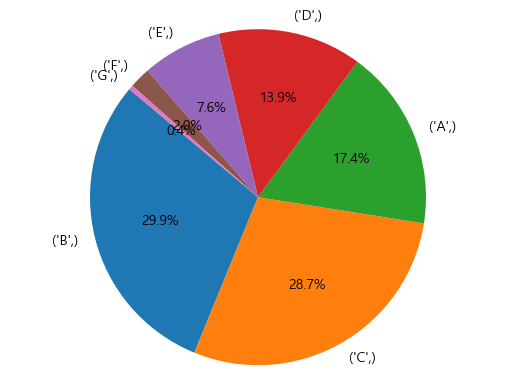

In [4]:
y_train_counts = y_train.value_counts()
plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 원형을 유지하도록 하는 옵션
plt.show()

## 결측치 확인
- 근로기간에 'Unknown' 이라고 결측치가 5671개 존재

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96294 entries, TRAIN_00000 to TRAIN_96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          96294 non-null  int64  
 1   대출기간          96294 non-null  object 
 2   근로기간          96294 non-null  object 
 3   주택소유상태        96294 non-null  object 
 4   연간소득          96294 non-null  int64  
 5   부채_대비_소득_비율   96294 non-null  float64
 6   총계좌수          96294 non-null  int64  
 7   대출목적          96294 non-null  object 
 8   최근_2년간_연체_횟수  96294 non-null  int64  
 9   총상환원금         96294 non-null  int64  
 10  총상환이자         96294 non-null  float64
 11  총연체금액         96294 non-null  float64
 12  연체계좌수         96294 non-null  float64
 13  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 11.0+ MB


In [6]:
train_df.isna().sum()

대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

In [7]:
for column in X_train.columns:  # 근로기간에 Unkown으로 결측치 있음
    unknown_count = (X_train[column] == 'Unknown').sum()
    print(f"{column}: {unknown_count}")

대출금액: 0
대출기간: 0
근로기간: 5671
주택소유상태: 0
연간소득: 0
부채_대비_소득_비율: 0
총계좌수: 0
대출목적: 0
최근_2년간_연체_횟수: 0
총상환원금: 0
총상환이자: 0
총연체금액: 0
연체계좌수: 0


## 기술통계를 통한 EDA

In [8]:
train_df.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [9]:
train_df.describe(include='O')

,대출기간,근로기간,주택소유상태,대출목적,대출등급
count,96294,96294,96294,96294,96294
unique,2,16,4,12,7
top,36 months,10+ years,MORTGAGE,부채 통합,B
freq,64479,31585,47934,55150,28817


## 시각화를 통한 EDA

### 수치형 데이터 시각화

In [10]:
for check_col in ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']:
    # print(check_col, " : ", len(set(X_train[check_col]))) # 중복없이 값종류 갯수
    print(check_col, " : ", len(X_train[check_col].unique())) # 중복없이 값종류 갯수

대출금액  :  1340
연간소득  :  7726
부채_대비_소득_비율  :  4025
총계좌수  :  109
최근_2년간_연체_횟수  :  20
총상환원금  :  27797
총상환이자  :  35626
총연체금액  :  109
연체계좌수  :  4


대출금액  bin :  68
연간소득  bin :  100
부채_대비_소득_비율  bin :  100
총계좌수  bin :  253
최근_2년간_연체_횟수  bin :  20
총상환원금  bin :  100
총상환이자  bin :  100


C:\Users\kssg1\AppData\Local\Temp\ipykernel_32084\1436924818.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


총연체금액  bin :  18
연체계좌수  bin :  4


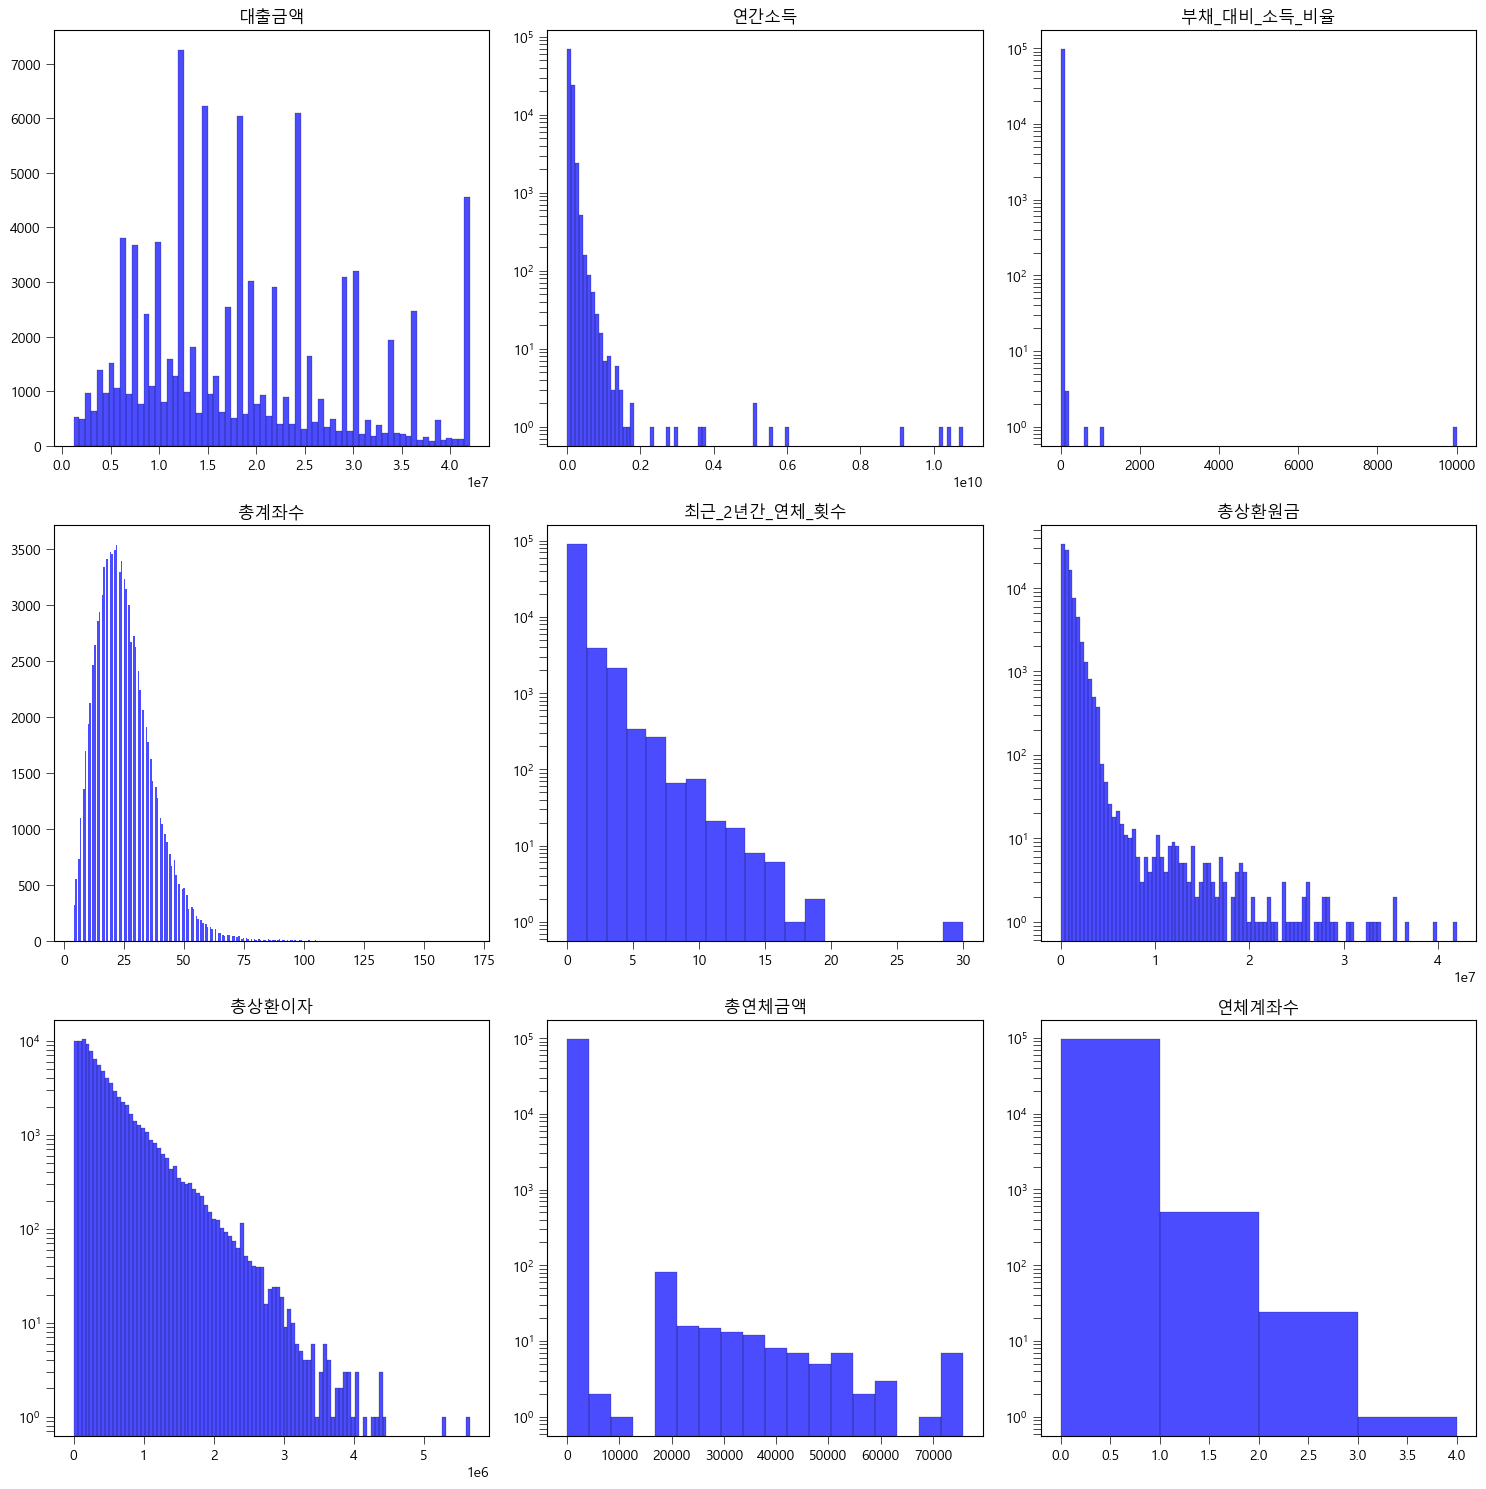

In [11]:
#수치형 변수 시각화
def get_3_hist_num(data:pd.DataFrame, columns:list, whether_log_scale: bool = True, 
                                        log_scale_threshold: float = 5000, bin_control: bool =True, num_bin_max: int = 300, num_bin_set: int = 80):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()
        n_bins = 'auto'
        
        if bin_control == True :
            # Freedman-Diaconis' Choice방식으로 bin 갯수 얼추 계산해본 뒤 판단
            entire_range = X_train[col].max() - X_train[col].min() # 데이터 값 최대와 최소 차이
            q1 = np.percentile(X_train[col], 25)
            q3 = np.percentile(X_train[col], 75)
            IQR = q3 - q1
            N = X_train[col].count()
            bin_width = 2 * (IQR / N**(1/3))
            num_bin = entire_range / bin_width
            # print(col, "의 bin : ", num_bin) # 점검용
            if len(set(data[col])) <= 20:
                n_bins = len(set(data[col]))
            elif (not math.isinf(num_bin)) and num_bin > num_bin_max:
                n_bins = num_bin_set
            else:
                n_bins = 'auto' # 지워도 괜찮을듯
        
        # # Wand 규칙을 사용하여 동적으로 bin의 개수 설정
        # if bar_width_ratio < bar_width_ratio_min:  # 전체 스케일에 대한 막대 두께의 비율이 너무 작으면
        #     n_bins = int(np.sqrt(len(set(data[col])))*1.0) 
        #     # 조금더 줄이면 깔끔히 잘보이지 않을까해서 0.8곱했다가 별차이없는듯해서 1.0으로 원 위치(원래 곱해진 것 따로 없었음)
        # else:
        #     n_bins = 'auto'
            
        hist, bins, _ = axes[row_idx, col_idx].hist(data[col], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7)
        num_bin_actual = len(bins) - 1  # 실제로 그려진 막대의 갯수
        #sns.histplot(data[col], ax=axes[row_idx, col_idx], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7, kde=False)
        
        axes[row_idx, col_idx].set_title(col)
        axes[row_idx, col_idx].tick_params(axis='both', which='both', direction='out', length=6, width=0.5)  # 눈금 표시
        
        bar_heights = [rect.get_height() for rect in axes[row_idx, col_idx].patches]
        max_height = max(bar_heights)
        min_height = max(min(bar_heights),1)
        
        # print(col, " 높이차는 이러함 : ", max_height / min_height, max_height, min_height) # 점검용
        print(col, " bin : ", num_bin_actual) # 점검용
        
        # 히스토그램 바의 높이 차이에 따라 리니어 스케일 또는 로그 스케일 선택
        if whether_log_scale == True and (max_height / min_height) > log_scale_threshold:
            axes[row_idx, col_idx].set_yscale('log')  # 로그 스케일로 변환
        else:
            axes[row_idx, col_idx].set_yscale('linear')  # 리니어 스케일로 유지
        
        # 전체 그래프 스케일에 대한 막대 자체의 두께 비율 계산
        total_width = axes[row_idx, col_idx].get_xlim()[1] - axes[row_idx, col_idx].get_xlim()[0]
        
        
        
        # 히스토그램 바의 두께가 조건에 따라 테두리 색 설정
        for rect in axes[row_idx, col_idx].patches:
            bar_width = rect.get_width()
            if bar_width / total_width > 0.005: # 그냥 저쯤보다 얇은 경우 테두리 없는게 나은듯해서 설정해줌
                rect.set_edgecolor('black')
            else:
                rect.set_edgecolor('none')  # 얇은 경우에는 테두리 없애기
        
        # # Seaborn axis 객체로부터 눈금 위치 확인
        # tick_locs = sns.histplot(data[col]).axes.get_xticks()
        # print(f"{col}의 현재 x 축 눈금 위치: {tick_locs}")

    # 남은 서브플롯에 빈 그래프 그리기
    for i in range(num_plots, num_rows * num_cols):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()  # 남은 서브플롯 비우기
        axes[row_idx, col_idx].axis('off')  # 빈 서브플롯 제거
        
    

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_hist_num(X_train, numeric_col, log_scale_threshold=8000, num_bin_max=270, num_bin_set=100)

<Axes: xlabel='총상환이자', ylabel='Count'>

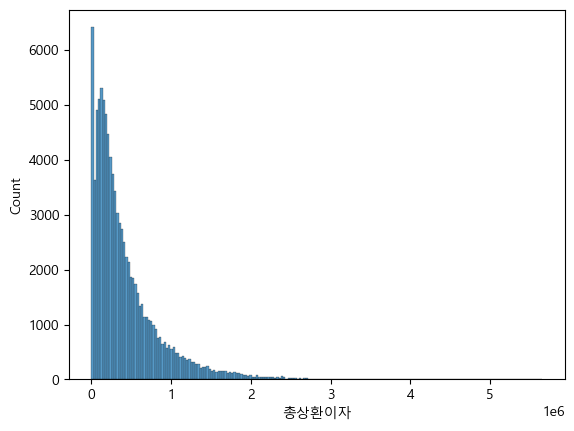

In [12]:
sns.histplot(X_train, x='총상환이자', bins=200)

In [13]:
X_train['총상환이자'].value_counts()

총상환이자
0.0          5444
156144.0       77
99312.0        73
85596.0        71
147276.0       70
             ... 
917364.0        1
774948.0        1
1131756.0       1
567804.0        1
818076.0        1
Name: count, Length: 35626, dtype: int64

In [14]:
X_train[X_train['부채_대비_소득_비율']>2000]['부채_대비_소득_비율'].value_counts() # -> 이상치로 판단

부채_대비_소득_비율
9999.0    1
Name: count, dtype: int64

In [15]:
print(X_train[X_train['최근_2년간_연체_횟수']==0]['최근_2년간_연체_횟수'].value_counts())
print(X_train[X_train['최근_2년간_연체_횟수']>0]['최근_2년간_연체_횟수'].value_counts())

최근_2년간_연체_횟수
0    76392
Name: count, dtype: int64
최근_2년간_연체_횟수
1     13079
2      3896
3      1430
4       697
5       338
6       178
7        86
8        67
9        40
10       35
11       21
12        9
14        8
13        8
16        4
18        2
15        2
17        1
30        1
Name: count, dtype: int64


In [16]:
X_train[X_train['총연체금액']<1]['총연체금액'].count()

96113

#### 판단
- '연간소득': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '부채_대비_소득_비율': 9999.0으로 이상치 하나 있는 것으로 판단됨
- '최근_2년간_연체_횟수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, log스케일은 할 필요 없을듯, 17이후 30이라 30을 이상치로 볼지는 염두만
- '총상환원금': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '총상환이자': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '총연체금액': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려
- '연체계좌수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>


### 범주형 데이터 시각화

In [17]:
# # 범주형 변수 시각화(countplot) # 개선 필요
# def get_3_countplot_category(data:pd.DataFrame, columns:list, log_scale_threshold: float = 5000):
#     """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

#     Args:
#         data (pd.DataFrame): 데이터프레임
#         columns (list): 컬럼 리스트
#         bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
#     """
#     num_plots = len(columns)
#     num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
#     num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
#     for i, col in enumerate(columns):
#         if num_rows == 1:
#             col_idx = i  # 수정된 부분
#             axes[col_idx].clear()
#             n_bins = 'auto'
#             sns.countplot(data=data, x=col, ax=axes[col_idx])  # 수정된 부분
#             max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
#             if max_length > 10:
#                 for tick in axes[col_idx][0].get_xticklabels():
#                     tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용
#         else:
#             row_idx, col_idx = divmod(i, 3)
#             axes[row_idx, col_idx].clear()
#             n_bins = 'auto'
#             sns.countplot(data=data, x=col, ax=axes[row_idx, col_idx])
#             max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
#             if max_length > 10:
#                 for tick in axes[col_idx][0].get_xticklabels():
#                     tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용

#     # 전체 그림 표시
#     plt.tight_layout()
#     plt.show()
# get_3_countplot_category(X_train, category_col)

In [18]:
category_col

['대출기간', '근로기간', '주택소유상태', '대출목적']

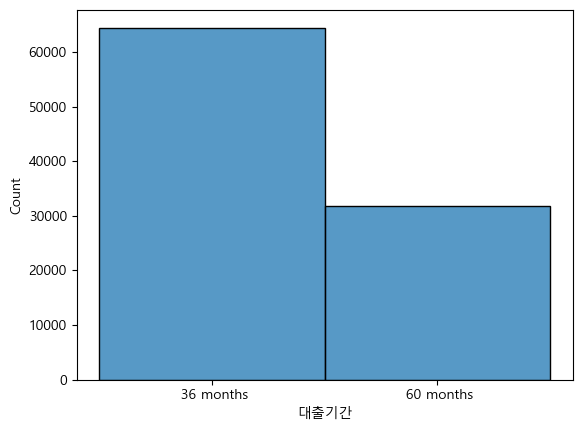

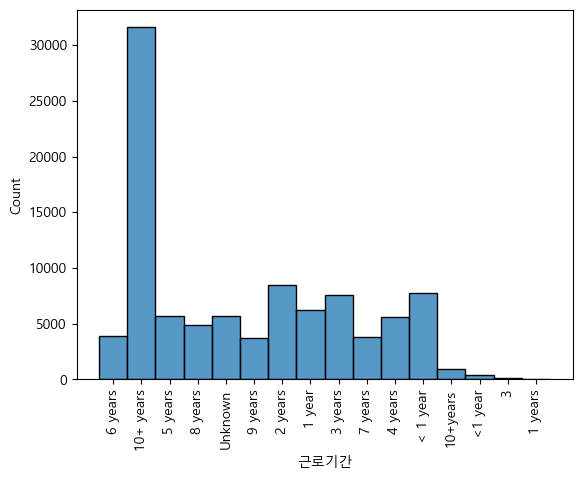

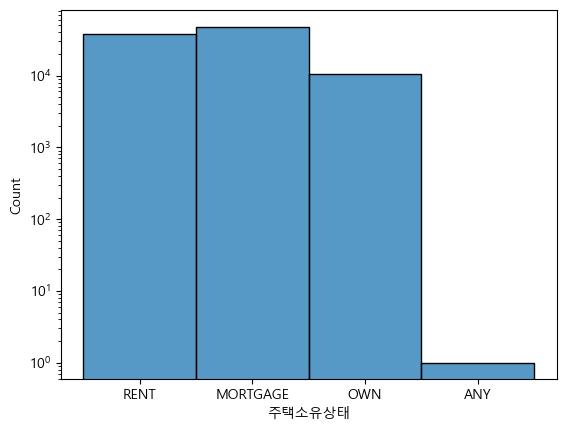

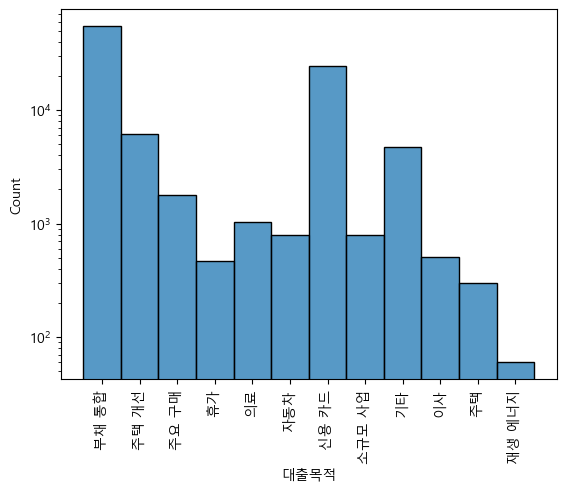

In [19]:
for plot_col in category_col:
    sns.histplot(X_train, x=plot_col)
    if plot_col in ['근로기간', '대출목적']:
        plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
    if plot_col in ['주택소유상태', '대출목적']:
        plt.yscale('log')  # y축을 로그 스케일로 변환
    plt.show()

In [20]:
X_train['근로기간'].unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

#### 근로기간에 잘못 적힌 값이 많은듯 
- 10+years를 10+ years 로 통일시켜주기
- < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
- 1 years를 1 year로 통일시켜주기
- 3을 3 years로 통일시켜주기


In [21]:
X_train[X_train['주택소유상태']=='ANY']['주택소유상태'].count()

1

#### 주택소유상태 표시 의미
주택 소유 상태를 나타내는 단어에서 각각의 의미는 다음과 같습니다:

RENT (임대): 주택을 소유하지 않고 대신 임대(또는 전세)하는 상태를 나타냅니다. 임차인은 일정 기간 동안 주택을 사용할 수 있지만 소유권은 없습니다.    
MORTGAGE (담보): 주택을 구매하기 위해 대출을 받고, 그 주택을 담보로 제공하는 상태를 나타냅니다. 대출을 상환하면서 주택의 소유권은 점차 대출을 상환하는 사람(대출자)에게 이전됩니다.     
OWN (소유): 주택을 소유하고 있는 상태를 나타냅니다. 소유자는 주택의 완전한 소유 및 권한을 가지며, 언제든지 주택을 판매하거나 대여할 수 있습니다.    
ANY (어느 것도 아닌): "ANY"는 일반적으로 선택지가 없음을 나타내며, 주택 소유 상태를 명시적으로 나타내지 않는 경우에 사용될 수 있습니다. 

In [22]:
X_train[X_train['대출목적']=='재생 에너지']['대출목적'].count()

60

# 데이터 전처리
- 이상치
	- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거
- 결측치
	- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
- 값 형식 불일치
	- 근로기간 값 형식이 일치 안된 것이 많아서
		- 10+years를 10+ years 로 통일시켜주기
		- < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
		- 1 years를 1 year로 통일시켜주기
		- 3을 3 years로 통일시켜주기
- 데이터 형식 바꿔주기
	- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- 데이터 비율 맞춰주기 위해 Oversampleing
	- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
    - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
- 컬럼 분리
	- 최근_2년간_연체_횟수, 총상환이자, 총연체금액, 연체계좌수 : 0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기

- 스케일링
	- 수동 로그스케일링:
		- 총연체금액: 로그스케일링해주기
- 인코딩
	- 순서 인코딩:
	- 레이블 인코딩: 대출기간, 근로기간
	- 원-핫 인코딩 : 주택소유상태, 대출목적
		- get_dummy:
		- 원-핫 인코딩:

## 이상치 제거
- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거

In [23]:
# def to_remove_Outlier(): # train 데이터에 대해서만 해주면 될듯하여 함수로 만들어줄 필요 없을듯
# 2000이상으로 값이 9999.0 하나 밖에 존재하지 않음
# 제거하고 나도 조금 떨어져 있는 듯한 녀석들이 있어서 전에 전처리 개인과제때 이상치 제거 함수 가져와서 통계적인 방법으로 이상치 제거하는게 나을듯
X_train = X_train[X_train['부채_대비_소득_비율']<3000] #<600

In [24]:
X_train.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629300e+04,9.629300e+04,96293.000000,96293.000000,96293.000000,9.629300e+04,9.629300e+04,96293.000000,96293.000000
mean,1.830414e+07,9.392770e+07,19.275952,25.304882,0.345664,8.225099e+05,4.282318e+05,54.381149,0.005805
std,1.032903e+07,9.956877e+07,9.624810,12.088616,0.919108,1.027749e+06,4.402120e+05,1414.776554,0.079967
min,1.200000e+06,1.440000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870160e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702280e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,1092.520000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [25]:
X_train['부채_대비_소득_비율'].skew()

17.82381591069744

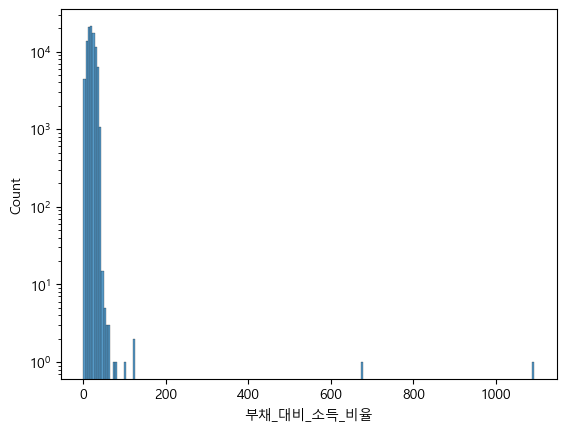

In [26]:
sns.histplot(data=X_train, x='부채_대비_소득_비율', bins=200)
plt.yscale('log')
plt.show()

##  결측치 처리
- 제거하거나 최빈값으로 대치해주면 될듯하나 일단 패스

In [27]:
# def get_non_missing(df):

## 값 형식 불일치 통일시켜주기
- 근로기간 값 형식이 일치 안된 것이 많아서
    - 10+years를 10+ years 로 통일시켜주기
    - < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
    - 1 years를 1 year로 통일시켜주기
    - 3을 3 years로 통일시켜주기

In [ ]:
#def Formal_unification():

## 데이터 형식 바꿔주기
- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기

In [ ]:
#def change_object_to_category():

## 데이터 비율 맞춰주기 위해 Oversampleing
- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
- SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용

In [28]:
# smnc = SMOTENC(categorical_features=category_col, random_state=42)
# X_train, y_train = smnc.fit_resample(X_train, y_train)
# # X_test, y_test = smnc.fit_resample(X_test, y_test) # 테스트 데이터는 건드리면 안될 것이라 판단되서 제외함

### oversampling한 뒤 결과 데이터 확인하기

In [ ]:
# X_train.info()
# print(X_train.isna().sum())
# display(X_train.describe())
# display(X_train.describe(include=['category']))
# X_train.describe(include = 'all')

## 컬럼 분리 (0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기)
- 최근_2년간_연체_횟수
- 총상환이자, 총연체금액
- 연체계좌수

## 스케일링
- 수동 로그스케일링:
	- 총연체금액: 로그스케일링해주기
- 학습 모델을 이용한 스케일링:
	- sd scaler(이상치가 많은 경우):
	- mm scaler(이상치가 거의 없는 경우):

### 수동 로그 스케일링

In [ ]:
# #balance의 값은 음수가 있기 때문에 최소값을 보정함
# balance_min = abs(min(X_train['balance'].min(), X_test['balance'].min()))
# X_train['balance'] = X_train['balance'] + balance_min
# X_test['balance'] = X_test['balance'] + balance_min

# #pdays도 표현상 이전 캠페인에서 연락한 적이 없다면 -1로 표시해놨기 때문에 음수가 있다 따라서 +1해줘서 음수를 없애준다
# X_train['pdays'] = X_train['pdays'] + 1
# X_test['pdays'] = X_test['pdays'] + 1

# # 로그스케일 적용
# for col in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
#     X_train[col] = np.log1p(X_train[col])
#     X_test[col] = np.log1p(X_test[col])

In [ ]:
# display(X_train.describe())

In [ ]:
# #로그스케일 변환 후 시각화
# get_3_hist_num(X_train, numeric_col)

### 학습 모델을 이용한 스케일링
- 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
- 표준화(sd_sc): 
- 정규화(mm_sc): 

In [ ]:
# def get_numeric_sc(X_train:pd.DataFrame, X_test:pd.DataFrame):
#     """데이터를 전달받아 수치형 변수 스케일링하는 함수

#     Args:
#         X_train (pd.DataFrame): train 데이터프레임
#         X_test (pd.DataFrame):  test 데이터프레임

#     Returns:
#         pd.DataFrame, pd.DataFrame: train, test 데이터프레임
#     """
#     # 수치형변수
#     # '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
#     #StandardScaler 적용할 변수 리스트
#     sc_col = ['pdays']
#     #MinMaxScaler 적용할 변수 리스트
#     mm_col = ['age','duration','day_of_week','balance','campaign','previous']
    
#     #모델 가져오기
#     sd_sc = StandardScaler()
#     mm_sc = MinMaxScaler()

#     #train, test 데이터변환(Standard Scaler이용)
#     sd_sc.fit(X_train[sc_col])
#     X_train[sc_col] = sd_sc.transform(X_train[sc_col])  #컬럼추가안해주고 바로 바꾸는지?
#     X_test[sc_col] = sd_sc.transform(X_test[sc_col])
    
#     #train, test 데이터변환(MinMax Scaler이용)
#     mm_sc.fit(X_train[mm_col])
#     X_train[mm_col] = mm_sc.transform(X_train[mm_col])
#     X_test[mm_col] = mm_sc.transform(X_test[mm_col])
    
#     return X_train, X_test

## 인코딩
- y 변수 인코딩: 
- 순서 인코딩: 
- 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩 : 주택소유상태, 대출목적
	- get_dummy:
	- 원-핫 인코딩:

### y 변수 인코딩

In [ ]:
#y 변수 인코딩 함수

In [30]:
['대출기간', '근로기간', '주택소유상태', '대출목적']

['대출기간', '근로기간', '주택소유상태', '대출목적']

### 범주형 데이터 전처리 (인코딩)
- 범주형 데이터: '대출기간', '근로기간', '주택소유상태', '대출목적'
- label encoding(le): ('marital', 'education'(할려면 범주 찾아서 다시 정렬해주긴 해야함), 'month') 정도 고려중인데 굳이 해줘야할까 생각중
- onehot encoding(oe) & get_dummies(gd): 둘중 하나로 통일해서 전부 해볼 듯하다      
우선적으로 그냥 get_dummies로 하고 시간 여유가 된다면 후에 더 건드려볼듯 함

In [ ]:
# def get_category(X_train:pd.DataFrame, X_test:pd.DataFrame):
#     """ 데이터를 전달받아 범주형 변수 더미화하는 함수

#     Args:
#         X_train (pd.DataFrame): train 데이터프레임
#         X_test (pd.DataFrame):  test 데이터프레임

#     Returns:
#         pd.DataFrame, pd.DataFrmae, list: train, test 데이터프레임, 더미화된 컬럼
#     """
    
# # 이부분 입력인자랑 전역변수랑 이름 중복되서 살짝 신경쓰임 나중에 시간 날때 수정해보던가 하기
#     #범주형변수
#     # 'job','marital','education','default','housing','loan','contact','month','poutcome'
    
#     # le = LabelEncoder()
#     # le2 = LabelEncoder()
#     # le3 = LabelEncoder()
    
#     # le.fit(X_train[['marital']])
#     # X_train['marital'] = le.transform(X_train[['marital']])
#     # X_test['marital'] = le.transform(X_test[['marital']])
    
#     # le2.fit(X_train[['education']])
#     # X_train['education'] = le2.transform(X_train[['education']])
#     # X_test['education'] = le2.transform(X_test[['education']])
    
#     # le3.fit(X_train[['month']])
#     # X_train['month'] = le3.transform(X_train[['month']])
#     # X_test['month'] = le3.transform(X_test[['month']])
    
#     # dumies_col = ['job','default','housing','loan','contact','poutcome'] #더미할 컬럼
    
#     # #범주형 컬럼 더미화 하기
#     # X_train_dummies = pd.get_dummies(X_train[dumies_col])
#     # X_test_dummies = pd.get_dummies(X_test[dumies_col])
    
#     #범주형 컬럼 더미화 하기
#     X_train_dummies = pd.get_dummies(X_train[category_col])
#     X_test_dummies = pd.get_dummies(X_test[category_col])
    
#     # 더미화한 변수를 기존 데이터셋에 합치기
#     X_train = pd.concat([X_train, X_train_dummies], axis = 1)
#     X_test = pd.concat([X_test, X_test_dummies], axis = 1)
    
#     return X_train, X_test, X_train_dummies.columns.to_list()

# 모델 수립 및 평가
- 모델은 후보로 염두 중인 것은 로지스터 회귀, 의사결정나무, 랜덤포레스트, knn(최근접이웃), Gradient Boosting, XGBoost, LightGBM     
    ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']
- 우선 일반적으로 이진분류에서 사용하는 평가지표인 <u>정확도</u>, 정밀도, 재현율, <u>F1 점수</u> 사용을 할 것이지만 
    보통 다중 분류에서는 각 클래스에 대한 지표를 계산한 후 평균 내는 방법 등이 추가로 필요하다고 하여 추가 조사 필요
- 전체적으로 다중 분류의 경우 아래와 같이 본 설명이 있어 추가로 이진분류와 어떻게 추가로 다르게 해줘야하는지는 찾아보아야 함
    * 레이블 처리: 이진 분류에서는 대상 변수가 두 가지 범주로 나뉘지만, 다중 분류에서는 대상 변수가 세 개 이상의 범주로 나뉩니다. 따라서 다중 분류 문제에서는 레이블을 적절히 처리해야 합니다.    
    * 성능 측정: 이진 분류에서는 정확도, 정밀도, 재현율, F1 점수 등을 사용하여 모델의 성능을 측정합니다. 다중 분류에서도 이러한 지표를 사용할 수 있지만, 각 클래스에 대한 지표를 계산한 후 이를 평균내는 방법 등이 추가로 필요합니다.     
    * 확률 추정: 일부 알고리즘(예: 로지스틱 회귀)은 이진 분류에서는 시그모이드 함수를, 다중 분류에서는 소프트맥스 함수를 사용하여 클래스 확률을 추정합니다.
    * 손실 함수: 일부 알고리즘(예: SVM, 신경망)은 이진 분류와 다중 분류에서 다른 손실 함수를 사용합니다.

rt의 경우 변수별 중요도를 추출할 수 있어서 그것을 통해 그래프 그리는 기능 추가시켜뒀음

### 변수 중요도 그래프 그리기(함수형태)

In [ ]:
# 변수 중요도 그래프 그리기
def draw_feature_importances(feature_importances_df, width_ratios=[3, 1], fontsize=10):
    import matplotlib.gridspec as gridspec
    # Create a figure object
    f = plt.figure(figsize=(15,20))
    
    # Create a gridspec object
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)  # Here, ax1 is three times wider than ax2

    # Create axes using the gridspec object
    ax1 = f.add_subplot(gs[0])
    ax2 = f.add_subplot(gs[1])

    # 레이아웃 조정
    f.subplots_adjust(wspace=0.05)

    # xaxis grid 만들기
    ax1.xaxis.grid()
    ax2.xaxis.grid()

    # 각각의 subplot ax1과 ax2에 barplot 그리기
    ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
    ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)
    
    # 각 서브플롯에 대해 막대그래프 끝에 값을 표시
    for p in ax1.patches:
        ax1.annotate(format(p.get_width(), '.4f'), 
                    (p.get_x() + p.get_width(), p.get_y()), 
                    xytext=(0, -9), 
                    textcoords='offset points',
                    ha='left', 
                    va='center', 
                    fontsize=fontsize)

    for p in ax2.patches:
        ax2.annotate(format(p.get_width(), '.4f'), 
                    (p.get_x() + p.get_width(), p.get_y()), 
                    xytext=(0, -9), 
                    textcoords='offset points',
                    ha='left', 
                    va='center', 
                    fontsize=fontsize)
    
    # 축 폰트 크기 설정
    ax1.tick_params(axis='both', labelsize=fontsize*1.2)  # 폰트 크게 조절 #실수float 가능
    ax2.tick_params(axis='both', labelsize=fontsize*1.2)  # 폰트 크게 조절

    # 각 subplot의 축범위 설정 (자동화 가능)
    ax1.set_xlim(0, max(feature_importances_df['importances'])/2)
    ax2.set_xlim(max(feature_importances_df['importances'])/2, max(feature_importances_df['importances']))

    # 각 subplot 눈금 표시하기
    ax1.set_xticks([i/100 for i in range(0, int(max(feature_importances_df['importances'])*100/2), 2)])  # 눈금 간격을 일정하게 조절
    ax2.set_xticks([i/100 for i in range(int(max(feature_importances_df['importances'])*100/2), int(max(feature_importances_df['importances'])*100), 2)])

    # x축 이름 없애줬음 통합해서 붙여줘야함
    ax1.set_xlabel("")
    ax2.set_xlabel("")  # x축 라벨 가운데 정렬

    # x축 label 가운데 위치
    f.text(0.5, 0.08, 'Importances', ha='center', va='center', fontsize=20)
    
    # y축 라벨 설정
    ax1.set_ylabel("Feature Names", fontsize=fontsize*1.4)
    ax2.set_ylabel("")

    # 서로 만나는 부분 y축 선 안보이게 제거
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # 오른 쪽 것의 y축 제거
    ax2.get_yaxis().set_visible(False)

    # 대각선 생략표시
    d = .9    
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

    # y축 값 표시
    ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
    ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
    # y축 눈금 간격 조정
    plt.yticks(fontsize=fontsize*1.2, rotation=30)
    
    # 그래프 제목
    plt.suptitle('Feature Importances', fontsize=fontsize*3, y=0.92)  # 제목 폰트 크게 조절
    
    # 그래프 표시
    plt.show()

# 이제 함수를 호출하여 그래프를 그릴 수 있습니다.


## 모델 적용 및 평가 함수

In [ ]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list, model_type:str = 'rf'):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
        model_type(str) : 무슨 모델 쓸지 결정 (default : 'rf')
    """
    #외부 전달인자를 내부변수에 할당
    X_train = train 
    X_test = test

    #일부 컬럼만 가져오기
    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    #모델가져오기 & 학습하기    &   # 학습하여 결과 저장
    if model_type in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
        if model_type == 'lor':
            from sklearn.linear_model import LogisticRegression
            model_lor = LogisticRegression()
            model_lor.fit(X_train, y_train)
            y_pred_train = model_lor.predict(X_train)
            y_pred_test = model_lor.predict(X_test)
            
        elif model_type == 'dt':
            from sklearn.tree import DecisionTreeClassifier
            model_dt = DecisionTreeClassifier(random_state=42)
            model_dt.fit(X_train, y_train)
            y_pred_train = model_dt.predict(X_train)
            y_pred_test = model_dt.predict(X_test)
            
        elif model_type == 'rf':
            from sklearn.ensemble import RandomForestClassifier
            model_rf = RandomForestClassifier(random_state=42)
            model_rf.fit(X_train, y_train)
            y_pred_train = model_rf.predict(X_train)
            y_pred_test = model_rf.predict(X_test)
            
            # 변수별 중요도 표시
            feature_names = model_rf.feature_names_in_
            feature_importances = model_rf.feature_importances_
            feature_importances_df = pd.DataFrame({"name": feature_names, "importances": feature_importances})
            #display(feature_importances_df)
            
            # # 그래프 크기 설정
            # plt.figure(figsize=(15, 15))
            # # 값에 100을 곱함
            # # 로그 스케일해줄 건데 값이 0~1이라 로그로 변환이 안되거나 너무 작게되서 표시가 안됨
            # # feature_importances_df['scaled_importances'] = feature_importances_df['importances'] * 100 

            # # 막대의 굵기 설정
            # barplot = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False) #, log_scale=True)

            # # 막대 레이블 표시
            # for index, value in enumerate(feature_importances_df['importances']):
            #     barplot.text(value, index, f'{value:.4f}', color='black', ha="left", va="center", fontsize=10)

            # # 그래프 제목 및 축 레이블 설정
            # plt.title('Feature Importances')
            # plt.xlabel('Importances')
            # plt.ylabel('Feature Names')

            # # 그래프 표시
            # plt.show()
            
            # # 그래프 크기 설정
            # # subplot
            # f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(15,20)) # 세로 높이를 더 크게 조절
            
            # # 레이아웃 조정
            # f.subplots_adjust(wspace=0.05)

            # # xaxis grid 만들기
            # ax1.xaxis.grid()
            # ax2.xaxis.grid()

            # # 각각의 subplot ax1과 ax2에 barplot 그리기
            # ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
            # ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)

            # # 축 폰트 크기 설정
            # ax1.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절
            # ax2.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절

            # # 각 subplot의 축범위 설정 (자동화 가능)
            # ax1.set_xlim(0, 0.09)
            # ax2.set_xlim(0.32, 0.34)

            # # 각 subplot 눈금 표시하기
            # ax1.set_xticks([0, 0.02, 0.04, 0.06, 0.08])  # 눈금 간격을 일정하게 조절
            # ax2.set_xticks([0.32, 0.34])

            # # x축 이름 없애줬음 통합해서 붙여줘야함
            # ax1.set_xlabel("")
            # ax2.set_xlabel("")  # x축 라벨 가운데 정렬

            # # x축 label 가운데 위치
            # f.text(0.5, 0.04, 'Importances', ha='center', va='center', fontsize=14)
            
            # # y축 라벨 설정
            # ax1.set_ylabel("Feature Names", fontsize=14)
            # ax2.set_ylabel("")

            # # 서로 만나는 부분 y축 선 안보이게 제거
            # ax1.spines['right'].set_visible(False)
            # ax2.spines['left'].set_visible(False)

            # # 오른 쪽 것의 y축 제거
            # ax2.get_yaxis().set_visible(False)

            # # 대각선 생략표시
            # d = .9    
            # kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
            # ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
            # ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

            # # y축 값 표시
            # ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # # y축 눈금 간격 조정
            # plt.yticks(fontsize=12, rotation=30)
            
            # # 그래프 제목
            # plt.suptitle('Feature Importances', fontsize=18)  # 제목 폰트 크게 조절
            
            # # 그래프 표시
            # plt.show()
            
            import matplotlib.gridspec as gridspec

            # Create a figure object
            f = plt.figure(figsize=(15,20))
            
            # Create a gridspec object
            gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Here, ax1 is three times wider than ax2

            # Create axes using the gridspec object
            ax1 = f.add_subplot(gs[0])
            ax2 = f.add_subplot(gs[1])

            # 레이아웃 조정
            f.subplots_adjust(wspace=0.05)

            # xaxis grid 만들기
            ax1.xaxis.grid()
            ax2.xaxis.grid()

            # 각각의 subplot ax1과 ax2에 barplot 그리기
            ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
            ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)
            
            # 각 서브플롯에 대해 막대그래프 끝에 값을 표시
            for p in ax1.patches:
                ax1.annotate(format(p.get_width(), '.4f'), 
                            (p.get_x() + p.get_width(), p.get_y()), 
                            xytext=(0, -9), 
                            textcoords='offset points',
                            ha='left', 
                            va='center', 
                            fontsize=10)

            for p in ax2.patches:
                ax2.annotate(format(p.get_width(), '.4f'), 
                            (p.get_x() + p.get_width(), p.get_y()), 
                            xytext=(0, -9), 
                            textcoords='offset points',
                            ha='left', 
                            va='center', 
                            fontsize=10)
            
            # 축 폰트 크기 설정
            ax1.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절
            ax2.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절

            # 각 subplot의 축범위 설정 (자동화 가능)
            ax1.set_xlim(0, 0.09)
            ax2.set_xlim(0.32, 0.34)

            # 각 subplot 눈금 표시하기
            ax1.set_xticks([0, 0.02, 0.04, 0.06, 0.08])  # 눈금 간격을 일정하게 조절
            ax2.set_xticks([0.32, 0.34])

            # x축 이름 없애줬음 통합해서 붙여줘야함
            ax1.set_xlabel("")
            ax2.set_xlabel("")  # x축 라벨 가운데 정렬

            # x축 label 가운데 위치
            f.text(0.5, 0.08, 'Importances', ha='center', va='center', fontsize=20)
            
            # y축 라벨 설정
            ax1.set_ylabel("Feature Names", fontsize=14)
            ax2.set_ylabel("")

            # 서로 만나는 부분 y축 선 안보이게 제거
            ax1.spines['right'].set_visible(False)
            ax2.spines['left'].set_visible(False)

            # 오른 쪽 것의 y축 제거
            ax2.get_yaxis().set_visible(False)

            # 대각선 생략표시
            d = .99    
            kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
            ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
            ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

            # y축 값 표시
            ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # y축 눈금 간격 조정
            plt.yticks(fontsize=12, rotation=30)
            
            # 그래프 제목
            plt.suptitle('Feature Importances', fontsize=30, y=0.92)  # 제목 폰트 크게 조절
            
            # 그래프 표시
            plt.show()
            #draw_feature_importances(feature_importances_df)
            
        elif model_type == 'knn':
            from sklearn.neighbors import KNeighborsClassifier
            model_knn = KNeighborsClassifier()
            model_knn.fit(X_train, y_train)
            y_pred_train = model_knn.predict(X_train)
            y_pred_test = model_knn.predict(X_test)
            
        elif model_type == 'gbm':
            from sklearn.ensemble import GradientBoostingClassifier
            model_gbm = GradientBoostingClassifier(random_state= 42)
            model_gbm.fit(X_train, y_train)
            y_pred_train = model_gbm.predict(X_train)
            y_pred_test = model_gbm.predict(X_test)
            
        elif model_type == 'xgb':
            from xgboost import XGBClassifier
            model_xgb = XGBClassifier(random_state= 42)
            model_xgb.fit(X_train, y_train)
            y_pred_train = model_xgb.predict(X_train)
            y_pred_test = model_xgb.predict(X_test)
            
        elif model_type == 'lgb':
            from lightgbm import LGBMClassifier
            model_lgb = LGBMClassifier(random_state= 42)
            model_lgb.fit(X_train, y_train)
            y_pred_train = model_lgb.predict(X_train)
            y_pred_test = model_lgb.predict(X_test)
    
    #평가표 생성
    result = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)]},
                            index = ['train','test'])
    
    print(model_type,"사용시")
    display(result.round(5))

## 전체 모델링 및 평가

#### 위에서 만들어 둔 스케일링과 인코딩 적용

In [ ]:
X_train, X_test = get_numeric_sc(X_train, X_test)
X_train, X_test, col_dummies = get_category(X_train,X_test)

#### 모델별 학습 및 평가

In [ ]:
# for model in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
#     get_score(X_train, X_test, col_dummies + numeric_col, model_type=model)
get_score(X_train, X_test, col_dummies + numeric_col, model_type='rf')

# 추가로 고려해야할 부분